**Train Model**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv(r"C:\Users\anass\Downloads\diabetes (2).csv")

In [3]:
df.shape

(768, 9)

In [4]:
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [5]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
print(df.describe())
print("Target distribution:\n", df['Outcome'].value_counts())


       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  

In [7]:
##Checking for missing or zero-like values
cols_zero_missing = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
print("Zeros in key columns:\n", (df[cols_zero_missing] == 0).sum())


Zeros in key columns:
 Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64


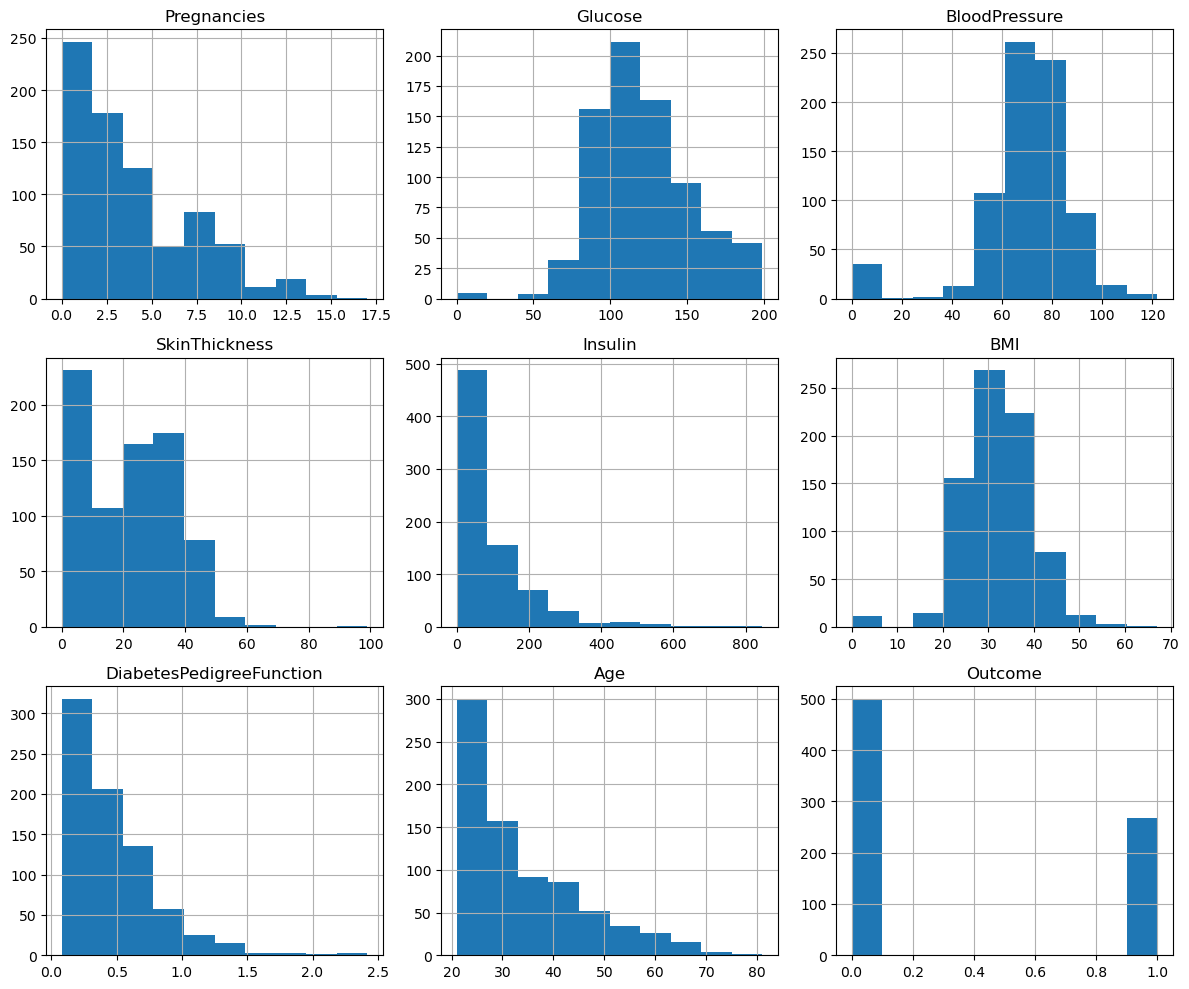

In [8]:
# Histograms
df.hist(figsize=(12,10))
plt.tight_layout()
plt.show()

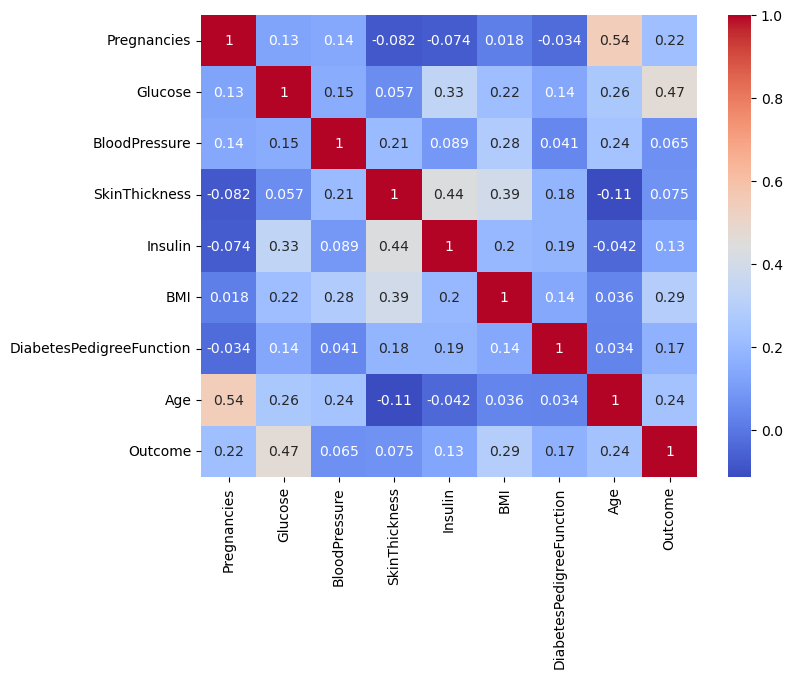

In [10]:
##Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.show()


**DATA PREPROCESSING**

In [11]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [12]:
df2 = df.copy()
df2[cols_zero_missing] = df2[cols_zero_missing].replace(0, np.nan)


In [13]:
X = df2.drop(columns=['Outcome'])
y = df2['Outcome']

In [15]:
numeric_features = X.columns.tolist()  # all features are numeric


In [16]:
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])


In [17]:
# No categorical features, so only numeric
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features)])


**MODEL BUILDING**

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [20]:
pipeline = Pipeline([('preprocessor', preprocessor),('clf', LogisticRegression(solver='liblinear', random_state=42, max_iter=1000))])


In [21]:
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l1','l2']
}

In [22]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [23]:
search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
search.fit(X_train, y_train)


,estimator,Pipeline(step...liblinear'))])
,param_grid,"{'clf__C': [0.01, 0.1, ...], 'clf__penalty': ['l1', 'l2']}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...)]"


In [24]:
best_model = search.best_estimator_
print("Best params:", search.best_params_)



Best params: {'clf__C': 0.1, 'clf__penalty': 'l2'}


**MODEL EVALUATION**

In [26]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score,f1_score, roc_auc_score, roc_curve,confusion_matrix, classification_report)

In [27]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

In [28]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7012987012987013
Precision: 0.5833333333333334
Recall: 0.5185185185185185
F1-score: 0.5490196078431373
ROC-AUC: 0.8098148148148149

Confusion matrix:
 [[80 20]
 [26 28]]

Classification report:
               precision    recall  f1-score   support

           0       0.75      0.80      0.78       100
           1       0.58      0.52      0.55        54

    accuracy                           0.70       154
   macro avg       0.67      0.66      0.66       154
weighted avg       0.69      0.70      0.70       154



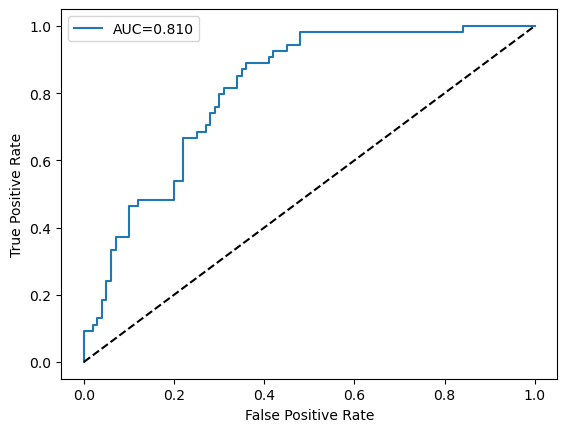

In [29]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

**INTERPRETATION**

In [30]:
##Extract coefficients
feat_names = numeric_features
coefs = best_model.named_steps['clf'].coef_[0]

coef_df = pd.DataFrame({
    'feature': feat_names,
    'coef': coefs,
    'odds_ratio': np.exp(coefs)}).sort_values(by='odds_ratio', ascending=False)

print("\nFeature importance (logistic regression coefficients):\n")
print(coef_df)


Feature importance (logistic regression coefficients):

                    feature      coef  odds_ratio
1                   Glucose  1.007409    2.738496
5                       BMI  0.569491    1.767368
0               Pregnancies  0.317626    1.373863
6  DiabetesPedigreeFunction  0.209928    1.233590
7                       Age  0.150772    1.162732
3             SkinThickness  0.061757    1.063703
2             BloodPressure -0.003450    0.996556
4                   Insulin -0.003651    0.996355


In [32]:
##Statistical significance with statsmodels
import statsmodels.api as sm


In [33]:
X_train_proc = best_model.named_steps['preprocessor'].transform(X_train)
X_sm = sm.add_constant(X_train_proc)
sm_logit = sm.Logit(y_train.reset_index(drop=True), X_sm).fit(disp=False)
print(sm_logit.summary())

                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  614
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                            8
Date:                Wed, 05 Nov 2025   Pseudo R-squ.:                  0.2992
Time:                        08:36:30   Log-Likelihood:                -278.19
converged:                       True   LL-Null:                       -396.97
Covariance Type:            nonrobust   LLR p-value:                 7.418e-47
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8772      0.110     -7.944      0.000      -1.094      -0.661
x1             0.3857      0.124      3.115      0.002       0.143       0.628
x2             1.2070      0.137      8.819      0.0